# DisCoPy v0.3.3 - new features

[1. Classical-quantum maps and mixed circuits](#1.-Classical-quantum-maps-and-mixed-circuits)

- `discopy.quantum.cqmap` implements Bob and Aleks' classical-quantum maps.
- Now `discopy.quantum.circuit` diagrams have two generating objects: `bit` and `qubit`.
- New boxes `Discard`, `Measure` and `ClassicalGate` can be simulated with `cqmap` or sent to `pytket`.

[2. ZX diagrams and PyZX interface](#2.-ZX-diagrams-and-PyZX-interface)

- `discopy.quantum.zx` implements diagrams with spiders, swaps and Hadamard boxes.
- `to_pyzx` and `from_pyzx` methods can be used to turn diagrams into graphs, simplify then back.

[3. Parametrised diagrams, formal sums and automatic gradients](#3.-Parametrised-diagrams,-formal-sums-and-automatic-gradients)

- We can use `sympy.Symbols` as variables in our diagrams (tensor, circuit or ZX).
- We can take formal sums of diagrams. `TensorFunctor` sends formal sums to concrete sums.
- Given a diagram (tensor, circuit or ZX) with a free variable, we can compute its gradient as a sum.

[4. Learning functors, diagrammatically](#4.-Learning-functors,-diagrammatically)

- We can use automatic gradients to learn functors (classical and/or quantum) from data.

## 1. Classical-quantum maps and mixed circuits

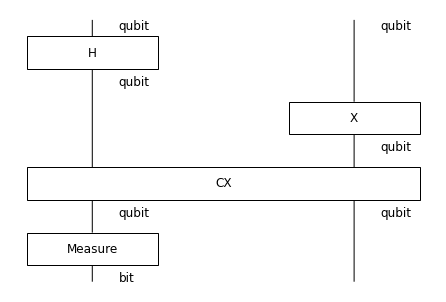

<AxesSubplot:>

In [1]:
from discopy.quantum import *

circuit = H @ X >> CX >> Measure() @ Id(qubit)
circuit.draw()

In [2]:
circuit.eval()

CQMap(dom=Q(Dim(2, 2)), cod=C(Dim(2)) @ Q(Dim(2)), array=[0. , 0. , 0. , ..., 0. , 0. , 0.5])

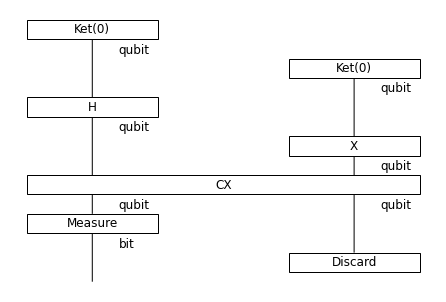

<AxesSubplot:>

In [3]:
circuit.init_and_discard().draw()

In [4]:
circuit.init_and_discard().eval()

CQMap(dom=CQ(), cod=C(Dim(2)), array=[0.5, 0.5])

In [5]:
circuit.to_tk()

tk.Circuit(2, 1).H(0).X(1).CX(0, 1).Measure(0, 0)

In [6]:
from pytket.backends.ibm import AerBackend
backend = AerBackend()
circuit.eval(backend)

Tensor(dom=Dim(1), cod=Dim(2), array=[0.515625, 0.484375])

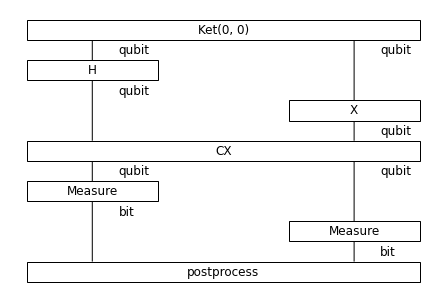

<AxesSubplot:>

In [7]:
postprocess = ClassicalGate('postprocess', n_bits_in=2, n_bits_out=0, array=[1, 0, 0, 0])
postprocessed_circuit = Ket(0, 0) >> H @ X >> CX >> Measure() @ Measure() >> postprocess
postprocessed_circuit.draw(aspect='auto')

In [8]:
postprocessed_circuit.to_tk()

tk.Circuit(2, 2).H(0).X(1).CX(0, 1).Measure(0, 0).Measure(0, 1).post_process(ClassicalGate('postprocess', n_bits_in=2, n_bits_out=0, array=[1, 0, 0, 0]))

In [9]:
postprocessed_circuit.eval(backend)

Tensor(dom=Dim(1), cod=Dim(1), array=[0.50585938])

## 2. ZX diagrams and PyZX interface

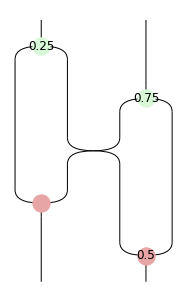

In [10]:
from discopy.quantum.zx import *
from pyzx import draw

bialgebra = Z(1, 2, .25) @ Z(1, 2, .75) >> Id(1) @ SWAP @ Id(1) >> X(2, 1) @ X(2, 1, .5)
bialgebra.draw(aspect='equal')
draw(bialgebra.to_pyzx())

From DisCoPy:


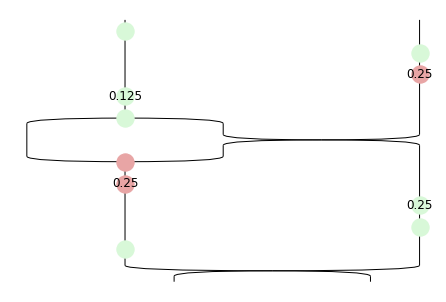

To PyZX:


And back!


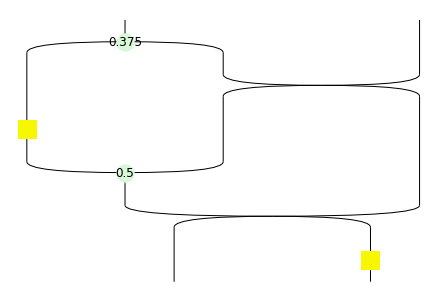

<AxesSubplot:>

In [11]:
from pyzx import generate, simplify

graph = generate.cliffordT(2, 5)
print("From DisCoPy:")
Diagram.from_pyzx(graph).draw()

print("To PyZX:")
draw(graph)
simplify.full_reduce(graph)
draw(graph)

print("And back!")
Diagram.from_pyzx(graph).draw()

## 3. Parametrised diagrams, formal sums and automatic gradients

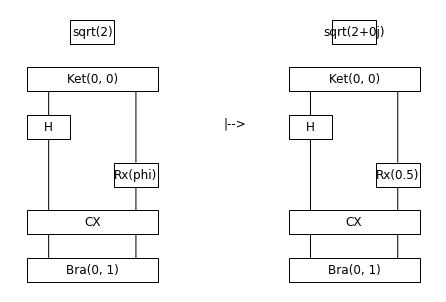

In [12]:
from sympy.abc import phi
from discopy import drawing
from discopy.quantum import *

circuit = sqrt(2) @ Ket(0, 0) >> H @ Rx(phi) >> CX >> Bra(0, 1)
drawing.equation(circuit, circuit.subs(phi, .5), symbol="|-->")

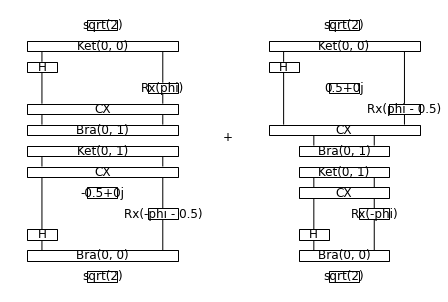

In [13]:
gradient = (circuit >> circuit[::-1]).grad(phi)
gradient.draw()

In [14]:
import numpy as np

x = np.arange(0, 1, 0.05)
y = np.array([circuit.subs(phi, i).measure() for i in x])
dy = np.array([gradient.subs(phi, i).eval().array for i in x])

Text(0, 0.5, 'Gradient')

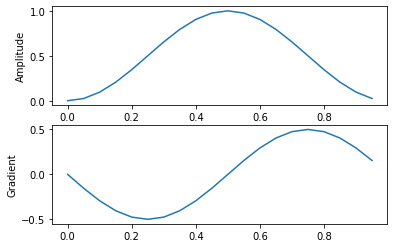

In [15]:
from matplotlib import pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(x, dy.real)
plt.ylabel("Gradient")

## 4. Learning functors, diagrammatically

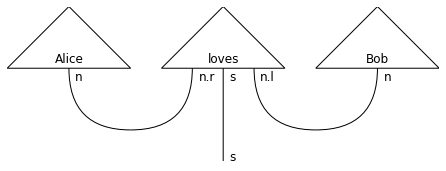

Our favorite toy dataset:
'Alice loves Alice' is false.
'Alice loves Bob' is true.
'Bob loves Alice' is true.
'Bob loves Bob' is false.


In [16]:
from discopy import *

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word("Alice", n), Word("loves", n.r @ s @ n.l), Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
parsing = {
    "{} {} {}".format(subj, verb, obj): subj @ verb @ obj >> grammar
    for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}
pregroup.draw(parsing["Alice loves Bob"], aspect='equal')

print("Our favorite toy dataset:")
corpus = {
    "{} {} {}".format(subj, verb, obj): int(obj != subj)
    for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}
for sentence, scalar in corpus.items():
    print("'{}' is {}.".format(sentence, "true" if scalar else "false"))

In [17]:
from sympy import symbols

parameters = symbols("a0 a1 b0 b1 c00 c01 c10 c11")

F = TensorFunctor(
    ob={s: 1, n: 2},
    ar={Alice: symbols("a0 a1"),
        Bob: symbols("b0 b1"),
        loves: symbols("c00 c01 c10 c11")})
gradient = F(parsing["Alice loves Bob"]).grad(*parameters)
gradient

Tensor(dom=Dim(8), cod=Dim(1), array=[1.0*b0*c00 + 1.0*b1*c01, 1.0*b0*c10 + 1.0*b1*c11, 1.0*a0*c00 + 1.0*a1*c10,
 1.0*a0*c01 + 1.0*a1*c11, 1.0*a0*b0, 1.0*a0*b1, 1.0*a1*b0, 1.0*a1*b1])

In [18]:
gradient.subs(list(zip(parameters, 8 * [0])))

Tensor(dom=Dim(8), cod=Dim(1), array=[0, 0, 0, 0, 0, 0, 0, 0])

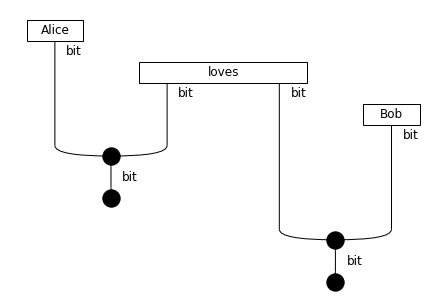

<AxesSubplot:>

In [19]:
from discopy.quantum import *

gates = {
    Alice: ClassicalGate('Alice', 0, 1, symbols("a0 a1")),
    Bob: ClassicalGate('Bob', 0, 1, symbols("b0 b1")),
    loves: ClassicalGate('loves', 0, 2, symbols("c00 c01 c10 c11"))}

F = CircuitFunctor(ob={s: Ty(), n: bit}, ar=gates)
F(parsing["Alice loves Bob"]).draw()

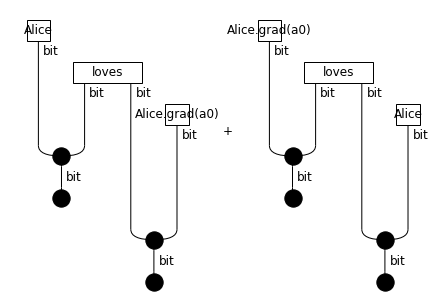

In [20]:
F(parsing["Alice loves Alice"]).grad(symbols("a0")).draw()

In [21]:
F(parsing["Alice loves Alice"]).grad(symbols("a0")).eval()

CQMap(dom=CQ(), cod=CQ(), array=[2.0*a0*c00 + 1.0*a1*c01 + 1.0*a1*c10])